Variance explained by PCs 1-6: [33.    5.47  1.39  1.25  1.21  1.17] %


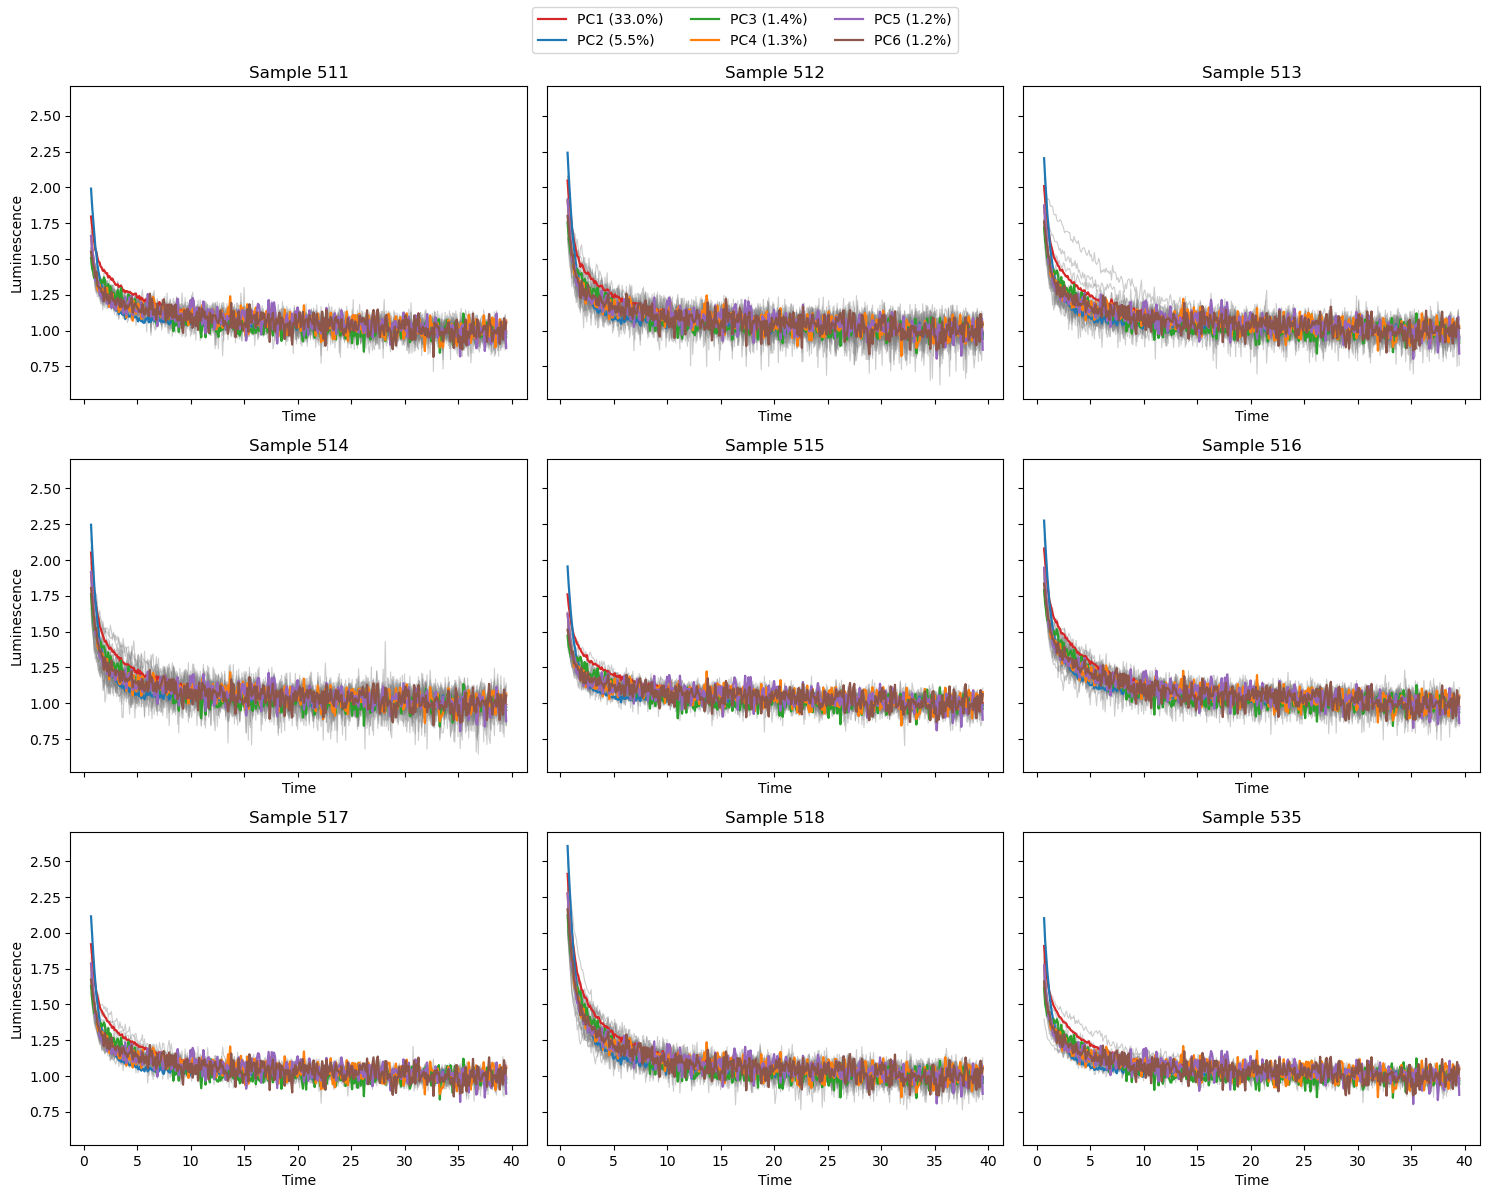

In [15]:
import os, pickle, numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# ---------------------------------------------------
# load data ---------------------------------------------------
pickle_path = 'output/processed_data.pkl'
if not os.path.exists(pickle_path):
    raise FileNotFoundError("Pickle file not found. Please check the path.")

with open(pickle_path, 'rb') as f:
    data_dict = pickle.load(f)

# helper: return (time, X, slice_names)
def sample_matrix(sample_key):
    df = data_dict[sample_key]
    time = df['Time'].astype(float).values
    slice_cols = df.columns.difference(['Time_index', 'Time'])
    X = df[slice_cols].to_numpy(dtype=float).T          # (n_slices, n_time)
    return time, X, slice_cols


# drop the key '518' from the data_dict

# if '518' in data_dict:
#     del data_dict['518']

# # drop 518 516 514
# data_dict = {k: v for k, v in data_dict.items() if k not in ['518', '516', '514']}

# ---------------------------------------------------
# 1) build a single matrix of all slices -------------
# ---------------------------------------------------
all_slices = []
for key in data_dict:
    _, X, _ = sample_matrix(key)
    all_slices.append(X)
X_all = np.vstack(all_slices)          # shape = (total_slices, n_time)

# centre by column (time-bin) means
X_all_center = X_all - X_all.mean(axis=0, keepdims=True)

# ---------------------------------------------------
# 2) PCA on combined data (first 6 components) -------
# ---------------------------------------------------
n_pc = 6
pca = PCA(n_components=n_pc).fit(X_all_center)
pcs = pca.components_                 # (6, n_time)
var_exp = pca.explained_variance_ratio_ * 100   # percentage

print("Variance explained by PCs 1-6:", np.round(var_exp, 2), "%")

# ---------------------------------------------------
# 3) plot: 3×3 grid, one panel per sample -----------
# ---------------------------------------------------
colors = ['tab:red', 'tab:blue', 'tab:green',
          'tab:orange', 'tab:purple', 'tab:brown']

sample_keys = sorted(data_dict.keys())            # 9 samples
n_rows, n_cols = 3, 3                              # handy for the test below
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 12), sharex=True, sharey=True)

for idx, (ax, key) in enumerate(zip(axes.ravel(), sample_keys)):   # <-- note idx
    time, Xs, _ = sample_matrix(key)

    # plot slices (grey)
    ax.plot(time, Xs.T, color='grey', alpha=0.4, lw=0.8)

    # sample-specific mean curve (for offsetting PCs)
    mean_curve = Xs.mean(axis=0)

    # overlay PCs 1-6
    for i in range(n_pc):
        ax.plot(time,
                mean_curve + pcs[i],
                color=colors[i],
                lw=1.6,
                label=f'PC{i+1} ({var_exp[i]:.1f}%)')

    ax.set_title(f'Sample {key}')
    ax.set_xlabel('Time')
    if idx % n_cols == 0:                         # <-- first column?
        ax.set_ylabel('Luminescence')

# common legend across top
handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=3)

fig.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


Variance explained by PCs 1-6: [33.    5.47  1.39  1.25  1.21  1.17] %


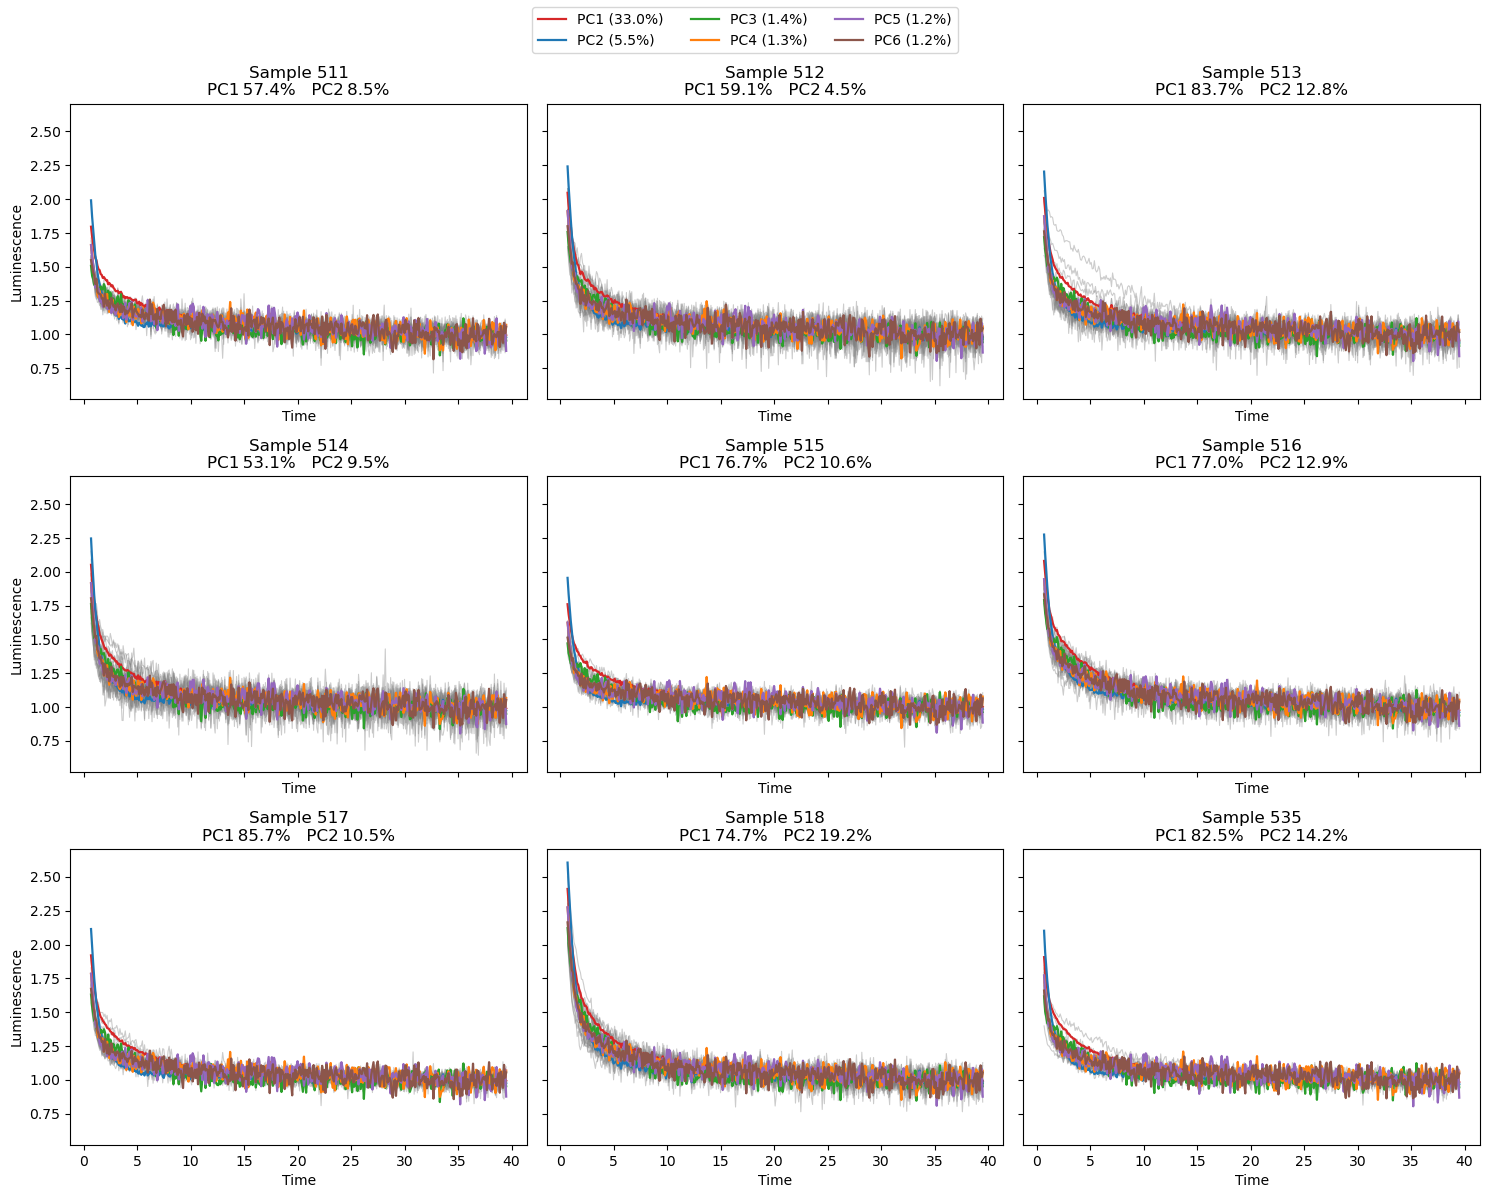

In [16]:
import os, pickle, numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# ---------------------------------------------------
# load data ---------------------------------------------------
pickle_path = 'output/processed_data.pkl'
if not os.path.exists(pickle_path):
    raise FileNotFoundError("Pickle file not found. Please check the path.")

with open(pickle_path, 'rb') as f:
    data_dict = pickle.load(f)

# helper: return (time, X, slice_names)
def sample_matrix(sample_key):
    df = data_dict[sample_key]
    time = df['Time'].astype(float).values
    slice_cols = df.columns.difference(['Time_index', 'Time'])
    X = df[slice_cols].to_numpy(dtype=float).T          # (n_slices, n_time)
    return time, X, slice_cols


# drop the key '518' from the data_dict

# if '518' in data_dict:
#     del data_dict['518']

# # drop 518 516 514
# data_dict = {k: v for k, v in data_dict.items() if k not in ['518', '516', '514']}

# ---------------------------------------------------
# 1) build a single matrix of all slices -------------
# ---------------------------------------------------
all_slices = []
for key in data_dict:
    _, X, _ = sample_matrix(key)
    all_slices.append(X)
X_all = np.vstack(all_slices)          # shape = (total_slices, n_time)

# centre by column (time-bin) means
X_all_center = X_all - X_all.mean(axis=0, keepdims=True)

# ---------------------------------------------------
# 2) PCA on combined data (first 6 components) -------
# ---------------------------------------------------
n_pc = 6
pca = PCA(n_components=n_pc).fit(X_all_center)
pcs = pca.components_                 # (6, n_time)
var_exp = pca.explained_variance_ratio_ * 100   # percentage

print("Variance explained by PCs 1-6:", np.round(var_exp, 2), "%")

# ---------------------------------------------------
# (everything up to, and including, the PCA section
#  is unchanged)
# ---------------------------------------------------

# ───────────────────────────────────────────────────
# NEW helper: variance explained in one sample
# ───────────────────────────────────────────────────
def pc12_share_in_sample(X_sample_centered, pcs_):
    """
    Return (%var_PC1, %var_PC2) of *this* sample given
    PCs derived from the combined data set.
    """
    # project the centred data onto all PCs we have
    scores = X_sample_centered @ pcs_.T          # (n_slices , n_pc)
    var_all   = np.var(scores, axis=0, ddof=0).sum()
    var_pc1   = np.var(scores[:, 0], ddof=0)
    var_pc2   = np.var(scores[:, 1], ddof=0)
    return 100 * var_pc1 / var_all, 100 * var_pc2 / var_all


# ---------------------------------------------------
# 3) plot: 3×3 grid, one panel per sample -----------
# ---------------------------------------------------
colors = ['tab:red', 'tab:blue', 'tab:green',
          'tab:orange', 'tab:purple', 'tab:brown']

sample_keys = sorted(data_dict.keys())            # 9 samples
n_rows, n_cols = 3, 3
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 12),
                         sharex=True, sharey=True)

for idx, (ax, key) in enumerate(zip(axes.ravel(), sample_keys)):
    time, Xs, _ = sample_matrix(key)

    # plot every slice in grey
    ax.plot(time, Xs.T, color='grey', alpha=0.4, lw=0.8)

    # mean curve for offsetting PCs visually
    mean_curve = Xs.mean(axis=0)

    # overlay PCs 1‑6 (still global PCs)
    for i in range(n_pc):
        ax.plot(time,
                mean_curve + pcs[i],
                color=colors[i],
                lw=1.6,
                label=f'PC{i+1} ({var_exp[i]:.1f}%)')

    # ───── compute sample‑specific variance shares ─────
    Xs_center = Xs - Xs.mean(axis=0, keepdims=True)
    share1, share2 = pc12_share_in_sample(Xs_center, pcs[:6])

    # title: sample name plus shares for PC1 & PC2
    ax.set_title(f'Sample {key}\n'
                 f'PC1 {share1:.1f}%   PC2 {share2:.1f}%')

    ax.set_xlabel('Time')
    if idx % n_cols == 0:
        ax.set_ylabel('Luminescence')

# common legend + layout are unchanged
handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=3)

fig.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()



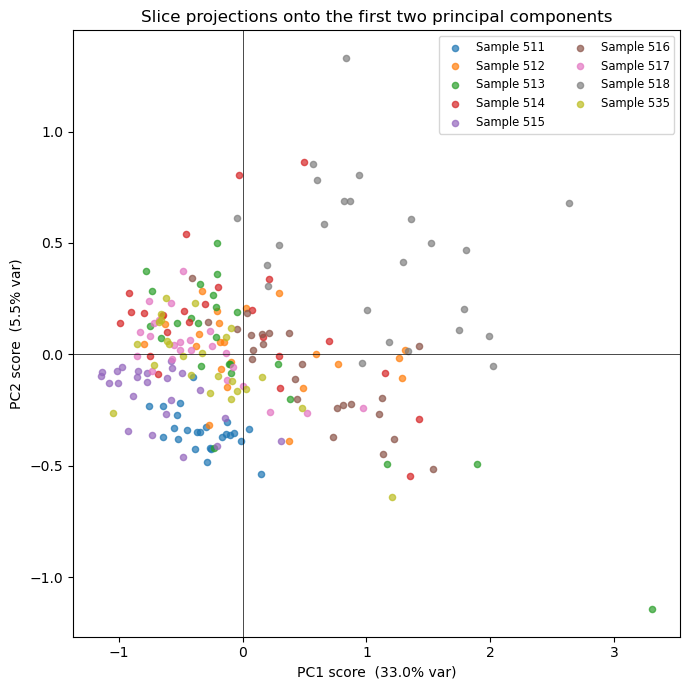

In [12]:
# ---------------------------------------------------
# Scatter of slice scores on PC1 vs PC2 (fixed)
# ---------------------------------------------------
import itertools
import matplotlib.pyplot as plt

# 1. scores = X_centered ⋅ PCsᵀ
scores = X_all_center @ pcs.T           # shape (n_slices_total, n_pc); we use [:,0:2]

# 2. one colour per sample
colour_cycle   = itertools.cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])
sample_colours = {key: next(colour_cycle) for key in sample_keys}

# 3. build an array that records the parent-sample of every slice
slice_sample = []
for key in sample_keys:
    _, X_s, _ = sample_matrix(key)
    slice_sample.extend([key] * X_s.shape[0])      # repeat the key for every slice
slice_sample = np.array(slice_sample)

# 4. scatter plot
plt.figure(figsize=(7, 7))
for key in sample_keys:
    idx = np.flatnonzero(slice_sample == key)
    plt.scatter(scores[idx, 0], scores[idx, 1],
                s=20, alpha=0.7, color=sample_colours[key],
                label=f'Sample {key}')

plt.axhline(0, lw=0.5, color='k')
plt.axvline(0, lw=0.5, color='k')
plt.xlabel(f'PC1 score  ({var_exp[0]:.1f}% var)')
plt.ylabel(f'PC2 score  ({var_exp[1]:.1f}% var)')
plt.title('Slice projections onto the first two principal components')
plt.legend(ncol=2, fontsize='small')
plt.tight_layout()
plt.show()


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\sklearn\cluster\_

GMM selected 2 components (lowest BIC = 542.3)


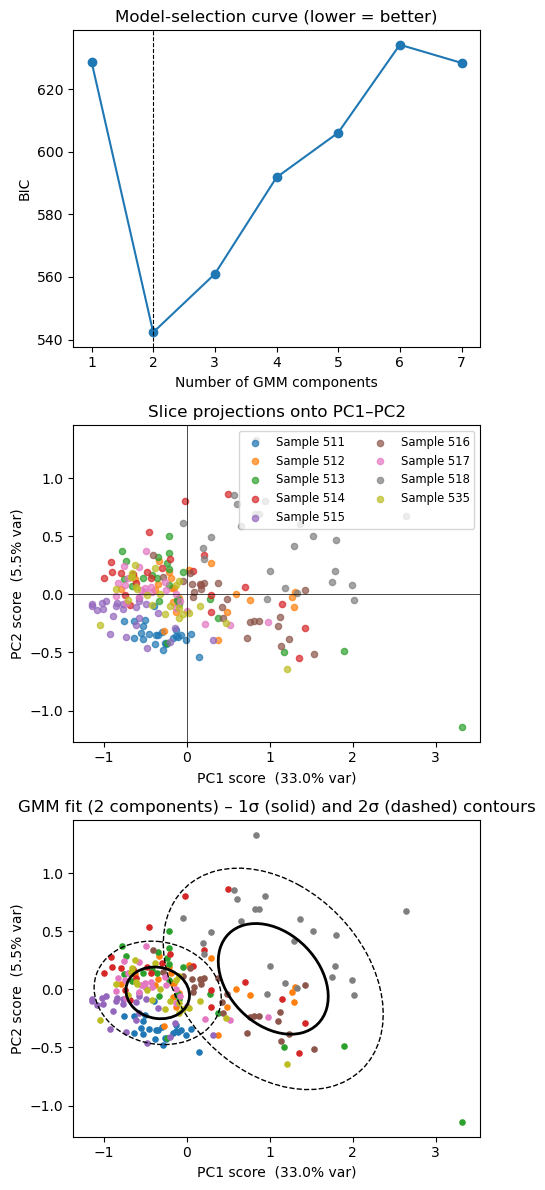

In [13]:
# ---------------------------------------------------
# Fit a Gaussian‑mixture model to PC1–PC2 scores
# ---------------------------------------------------
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

# --- 1. model selection via BIC ----------------------------------------------
X_2d = scores[:, :2]       # (n_slices_total, 2)

bic_vals, gmms = [], []
for k in range(1, 8):      # try 1–7 components
    gmm_k = GaussianMixture(
        n_components=k,
        covariance_type='full',
        random_state=0
    ).fit(X_2d)
    bic_vals.append(gmm_k.bic(X_2d))
    gmms.append(gmm_k)

best_idx = int(np.argmin(bic_vals))
gmm      = gmms[best_idx]
print(f'GMM selected {gmm.n_components} components (lowest BIC = {bic_vals[best_idx]:.1f})')

# --- 2. helper: draw one‑ and two‑sigma ellipses -----------------------------
def draw_gmm_ellipses(ax, gmm, n_sigma=1, **kwargs):
    """Add n‑sigma error ellipses of a fitted GMM to *ax*."""
    for mean, covar, weight in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        # eigen‑decomposition of covariance
        vals, vecs = np.linalg.eigh(covar)
        order = vals.argsort()[::-1]
        vals, vecs = vals[order], vecs[:, order]
        angle = np.degrees(np.arctan2(vecs[1, 0], vecs[0, 0]))
        width, height = 2 * n_sigma * np.sqrt(vals)   # 2σ (full width)
        ell = Ellipse(
            xy=mean,
            width=width,
            height=height,
            angle=angle,
            **kwargs
        )
        ax.add_patch(ell)

# --- 3. plot: BIC curve + scatter + GMM contours ------------------------------
fig = plt.figure(figsize=(5, 12))

# 3a) BIC curve (optional but handy)
ax_bic = fig.add_subplot(3, 1, 1)
ax_bic.plot(range(1, 8), bic_vals, marker='o')
ax_bic.set_xlabel('Number of GMM components')
ax_bic.set_ylabel('BIC')
ax_bic.set_title('Model‑selection curve (lower = better)')
ax_bic.axvline(best_idx + 1, color='k', ls='--', lw=0.8)

# 3b) upper scatter (your original plot, now in a subplot)
ax0 = fig.add_subplot(3, 1, 2)
for key in sample_keys:
    idx = np.flatnonzero(slice_sample == key)
    ax0.scatter(
        scores[idx, 0], scores[idx, 1],
        s=20, alpha=0.7, color=sample_colours[key],
        label=f'Sample {key}'
    )
ax0.axhline(0, lw=0.5, color='k')
ax0.axvline(0, lw=0.5, color='k')
ax0.set_xlabel(f'PC1 score  ({var_exp[0]:.1f}% var)')
ax0.set_ylabel(f'PC2 score  ({var_exp[1]:.1f}% var)')
ax0.set_title('Slice projections onto PC1–PC2')
ax0.legend(ncol=2, fontsize='small')

# 3c) lower panel – same scatter + fitted Gaussians
ax1 = fig.add_subplot(3, 1, 3, sharex=ax0, sharey=ax0)
for key in sample_keys:
    idx = np.flatnonzero(slice_sample == key)
    ax1.scatter(
        scores[idx, 0], scores[idx, 1],
        s=14, alpha=1, color=sample_colours[key]
    )
draw_gmm_ellipses(ax1, gmm, n_sigma=1, lw=2, edgecolor='black', facecolor='none')
draw_gmm_ellipses(ax1, gmm, n_sigma=2, lw=1, ls='--', edgecolor='black', facecolor='none')
ax1.set_xlabel(f'PC1 score  ({var_exp[0]:.1f}% var)')
ax1.set_ylabel(f'PC2 score  ({var_exp[1]:.1f}% var)')
ax1.set_title(f'GMM fit ({gmm.n_components} components) – 1σ (solid) and 2σ (dashed) contours')

fig.tight_layout()
plt.show()


# 518 和 516， 514， 512物源接近

# 535 和513， 517 物源接近
# 511 和515 物源接近
